<a href="https://colab.research.google.com/github/gkanfer/AI-PS/blob/master/bayesCell_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
{
    "tags": [
        "hide-cell"
    ]
}
!pip install AIPySdeAnalyzer==0.2.8
!pip install numpyro

In [7]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [5]:
import numpyro
numpyro.__version__

'0.14.0'

<center><H1>Using the Bayesian Approach with PyMC to Analyze Functional Genomics Screens<H1></center>
In the dynamic fields of experimental cell biology and genetics, the tools we use to analyze our data are crucial. For many researchers, popular software packages like edgeR or DESeq2 might seem like the go-to options for analyzing data. However, there are instances where these tools might not be enough. In such cases, customizing your own statistical inference framework tailored specifically to your data becomes paramount. This is where Bayesian inference can offer invaluable insights.

Biological systems are complex and often chaotic, which means investigating them requires a thorough and nuanced approach. To illustrate this, let's delve into a case study from the experimental realm of cell biology, focusing on CRISPR-based functional genomic screening. While this notebook employs several advanced concepts, such as prior prediction analysis, centered vs. non-centered reparameterization in hierarchical modeling, and an in-depth explanation of varying effects, the primary focus here is on practical application and implementation, rather than on reintroducing these well-explained concepts.

Each of these topics could easily be the subject of its own detailed blog post. However, my objective today is to share an approach that I've found particularly effective in tackling data from this field. Future posts will explore these subjects more thoroughly.

<H2>The Challenge at Hand</H2>

The problem we're addressing is not new but continues to be relevant: how to analyze vast amounts of genetic data when our sample sizes are limited. This is often referred to as the "large p, small n" problem. It’s a challenge that traces back to the foundational work that persists in modern techniques like CRISPR and RNAi screens, which aim to decipher gene functions at the molecular level. To navigate this challenge, we propose a solution rooted in Bayesian and causal inference, designed specifically to identify upregulated genes from such datasets.

Drawing inspiration from Richard McElreath’s “Fortune Telling Frameworks,” our analysis approach includes setting clear goals, defining assumptions, establishing priors and prior prediction analysis, simulating and comparing models, and reporting findings. Importantly, this approach is iterative, allowing for adjustments as new data emerges.

A critical first step in our analysis is acknowledging the high level of dispersion in our dataset. This dispersion stems from biological variability and experimental conditions, such as a high multiplicity of infection (MOI), which complicates the analysis by introducing collider effects.

<H2>Simulating the Dynamics of CRISPR Screens and Diving Into EDA</H2>

Delving into the world of CRISPR screen simulations requires precise tools and methods. We've developed a Python package specifically designed to simulate the complex dynamics of CRISPR screens, providing control over a wide range of parameters.

### Getting Started with the Package

To begin, install the package using the following command:

```python
pip install AIPySdeAnalyzer==0.2.8
```

This package is your gateway to generating realistic CRISPR screen data for analysis.

### Phase 1: Simulating Initial sgRNA Interactions

Our simulation starts with the initial interaction between cells and sgRNAs. We model this as $H_{t_0}$, representing sgRNA read counts before the screening process begins. The model relies on a multinomial distribution influenced by initial plasmid read counts ($m$), which follow a negative binomial distribution:

\begin{align*}
f(H_{t_0}) = \frac{\binom{r}{H_{t_0}}\binom{N-r}{n-H_{t_0}}}{\binom{N}{n}},
\end{align*}

This equation factors in infection efficiency and the prior abundance of sgRNAs, where $r$ is total successful sgRNA incorporations, $n$ is total cells, and $N$ is virus particles.

We simulate a scenario where each of 300 genes is targeted by 5 unique sgRNAs. You have the flexibility to define key parameters, such as the number of genes that are true targets and the number of sgRNAs that effectively target these genes. This phase prepares our dataset for further analysis.

### Phase 2: Post-Screening Simulation

After the initial setup, phase 2 simulates the post-screening outcomes, focusing on sgRNAs that successfully target key genes. This phase introduces variability through a binomial distribution, reflecting the random nature of biological systems and experimental conditions. We also simulate false positive rates to mimic potential errors in the screening process.

The step-by-step approach in this phase allows us to:

1. Identify sgRNAs that effectively target specific genes.
2. Simulate the selection process with a degree of randomness.
3. Assess the impact of sgRNAs on cell phenotype, giving insights into their effectiveness.

To run the simulation and generate data, use the following command:

```python
runSimulation(targetNum = 5, geneNum = 300, effectSgRNA = 2, getData = True, mu = 20, a = 1.2, low = 1, high = 3, size = 10_000, FalseLimits = (0.05,0.25), ObservationNum = (20,3))
```

This operation produces a dataset where 300 genes, targeted by 5 sgRNAs each, are grouped according to their sample categories: initial master plasmid (M), before screening ($H_{t_0}$), and after screening ($H_{t_1}$).

By following these steps, researchers can generate simulated data that closely mirrors real CRISPR screen dynamics, laying a solid foundation for in-depth exploratory data analysis.


In [2]:
{
    "tags": [
        "hide-cell"
    ]
}
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
import jax
import warnings
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
plt.style.use('default')
#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
# plt.style.use('fivethirtyeight')
from aipys_analyse.simulation.runSimulation import runSimulation
df = runSimulation(targetNum = 3, geneNum = 20, effectSgRNA = 4,getData = True, mu = 20, a = 1.2,low = 1, high = 3,size = 10_000,FalseLimits = (0.05,0.5),ObservationNum = (70,3))

dftall = df.dfTall
dftall.loc[dftall['readCount'] <= 0, 'readCount'] = 1
dftall.loc[dftall['readCount'] % 1 != 0, 'readCount'] = 1

3380it [00:00, 16655.55it/s]

generates ht0 sample


10000it [00:00, 17675.43it/s]
141it [00:02, 51.90it/s]


Data generation is done


142it [00:03, 47.23it/s]


Data generation is done


142it [00:05, 25.56it/s]


Data generation is done


100%|██████████| 100/100 [00:00<00:00, 14375.38it/s]


unpacking


100%|██████████| 96/96 [00:00<00:00, 163.18it/s]


In [5]:
dftall.sample(5)

,Gene,sgRNA,class,readCount,logRcount,tag
597,DAGLA,DAGLA_-_61447945.23-P1P2,M,18,2.995732,2
805,FMN2,FMN2_-_240255238.23-P1P2,M,55,4.043051,2
89,YBEY,YBEY_-_47706329.23-P1P2,Ht0,11,2.564949,0
306,CCDC19,CCDC19_-_159895281.23-P1P2,Ht1,46,3.871201,1
282,YBEY,YBEY_-_47706339.23-P1P2,Ht0,131,4.890349,0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


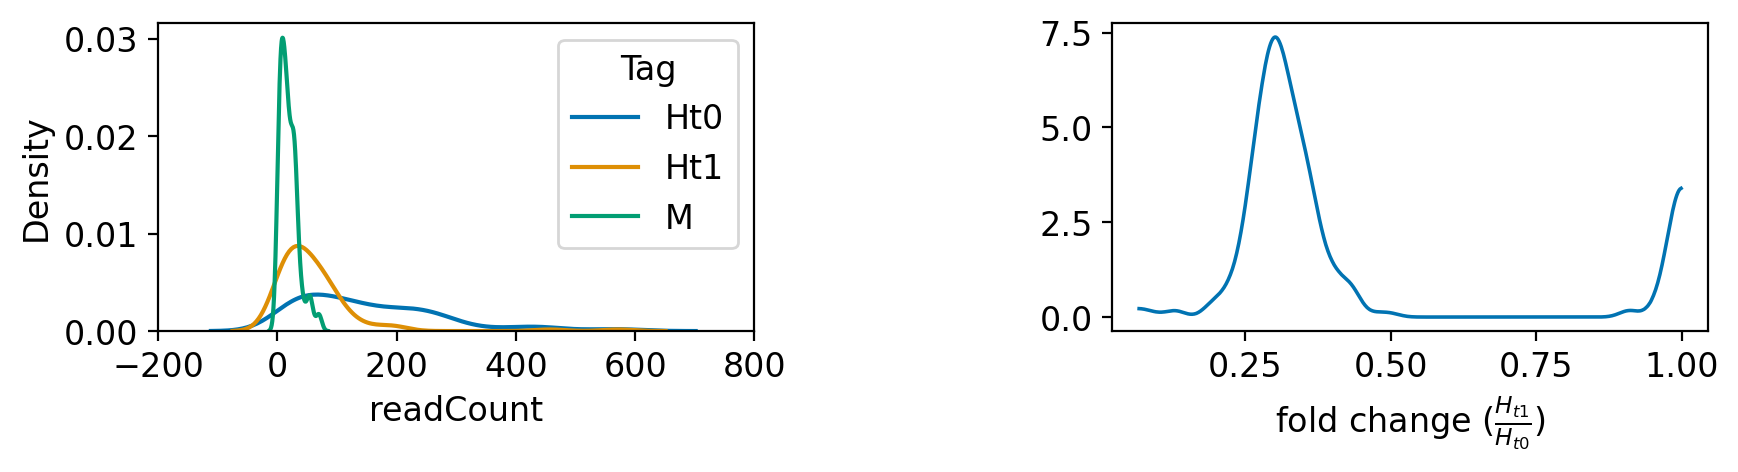

In [3]:
{
    "tags": [
        "hide-input",
    ]
}
plt.rcParams['font.size'] = 12
palette1 = sns.color_palette("colorblind",9)
selcolor = [palette1[i] for i in [0, 1, 2]]
tags = dftall['class'].unique()
color_dict = dict(zip(tags, selcolor))

fig, axes = plt.subplots(1, 2,figsize=(10, 2))

axes = axes.ravel()
for tag in tags:
    sns.kdeplot(dftall[dftall['class'] == tag]['readCount'], ax=axes[0], color=color_dict[tag], label=tag)
axes[0].legend(title='Tag')
x_ticks = axes[0].get_xticks()
new_x_ticks = np.linspace(start=min(x_ticks), stop=max(x_ticks), num=6)
axes[0].set_xticks(new_x_ticks)

_ = az.plot_kde(dftall.loc[dftall["tag"]==1,"readCount"].values / dftall.loc[dftall["tag"]==0,"readCount"].values, plot_kwargs={"color":selcolor[0]},textsize = 12,ax = axes[1])
axes[1].set_xlabel(r"fold change ($\frac{H_{t1}}{H_{t0}}$)")
# axes[3].set_ylabel(r"$H_{t1}$")
plt.subplots_adjust(wspace = 0.6)

Incorporating insights from Richard McElreath's *Statistical Rethinking*, one critical step in the Bayesian framework is to define a clear research objective. This means specifying precisely what we aim to understand or predict for our investigation. Given the data, our prior knowledge (including expertise in screens and protein enrichment analysis), and the process through which the data was generated, our question becomes: What is the probability that Gene X is more abundant in the post-screen sample $H_{t_1}$? When considering the distribution of the $H_{t_1}$ sample, we might initially think of a normal distribution. However, given the nature of read count data in such analyses, a negative-binomial distribution is often more suitable. Translating this into mathematical notation gives us:

$$
\begin{align*}
&\begin{aligned}
\text{(1)}\\
(H_{t_1,i} | H_{t_0,i}) &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha + \beta \times H_{t_0,i}\\
\end{aligned}
&&
\begin{aligned}
\text{OR}\\
\end{aligned}
&&&
\begin{aligned}
\text{(2)}\\
(H_{t_1,i} | H_{t_0,i}) &\sim \text{NB}(\mu, \alpha)\\
\mu &= \alpha + \beta \times H_{t_0,i}\\
\end{aligned}
\end{align*}
$$

The next step involves choosing the most appropriate priors for the $\beta$ parameters. By tapping into public data on CRISPR screens, such as that available from [BioGrid ORCS](https://orcs.thebiogrid.org/), we learn that the distribution of fold changes spans from -4 to 4, guiding us toward a weakly informative prior range.

<ipython-input-4-c9891ff53dc5>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('https://raw.githubusercontent.com/gkanfer/AIPySdeAnalyzer/main/Prior_distribution.png')


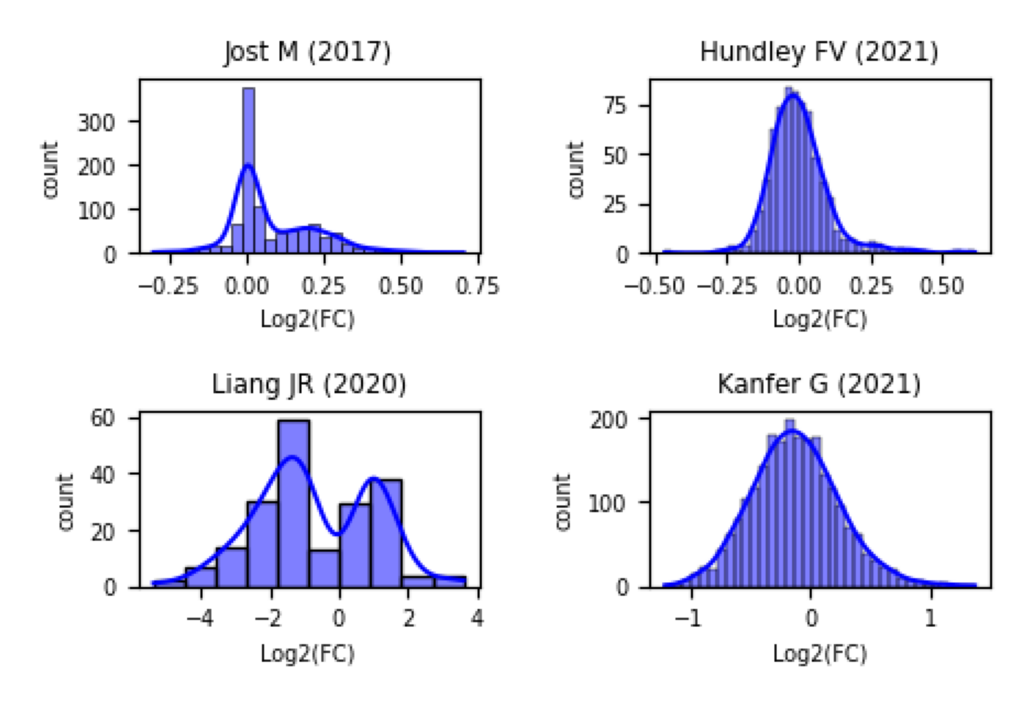

In [4]:
{
    "tags": [
        "hide-cell"
    ]
}
import imageio
# Read the image file
img = imageio.imread('https://raw.githubusercontent.com/gkanfer/AIPySdeAnalyzer/main/Prior_distribution.png')
# Display the image
_ = plt.imshow(img)
plt.axis('off')  # remove axis
plt.show()

A particularly useful tool in defining these priors is the `find_constrained_prior` feature within PyMC. The process of selecting priors, along with prior predictive analysis, is comprehensively detailed in an insightful blog post.

This structure not only sets the stage for constructing our model but also ensures that our approach is grounded in both theoretical knowledge and empirical evidence, effectively bridacing the gap between statistical theory and practical application in experimental biology.

Next, we'll build these models and see how they compare.

First load data:

In [6]:
dftall_h0 = dftall.loc[dftall["tag"]==0,:]
dftall_h1 = dftall.loc[dftall["tag"]==1,:]
dftall_M = dftall.loc[dftall["tag"]==2,:]

sgRNA, mn_sgRNA = dftall_h0.sgRNA.factorize()
Genes, mn_Genes = dftall_h0.Gene.factorize()
h0 = dftall_h0.readCount.values
h1 = dftall_h1.readCount.values
M = dftall_M.readCount.values
xy = np.ones((len(h0),2))
xy[:,0] = h0
xy[:,1] = h1
coords = {"sgRNA": mn_sgRNA,"Genes": mn_Genes}

Complete pooling Normal likelihood model:

In [7]:
with pm.Model(coords=coords) as Normal:
  beta = pm.Normal("beta", 1,1)

  Mu = pm.Deterministic("Mu",h1+beta*h0)
  sigma = pm.Gamma("sigma",mu = 1, sigma = 1)

  count = pm.Normal("count",mu = Mu, sigma = sigma, observed=h1)
  trace_NCP = pm.sample(1000, tune=1000, nuts_sampler="numpyro", target_accept=0.95,chains = 4, random_seed=RANDOM_SEED)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Complete pooling Normal Negative-Binomial model:

In [8]:
with pm.Model(coords=coords) as NB_CP:
  beta = pm.Normal("beta", 1,1)

  Mu = pm.Deterministic("Mu",h1+beta*h0)
  alpha = pm.Gamma("alpha",mu = 28.5, sigma = 10.5)

  count = pm.NegativeBinomial("count",mu = Mu, alpha = alpha, observed=h1)
  trace_NBCP = pm.sample(1000, tune=1000, nuts_sampler="numpyro", target_accept=0.95,chains = 4, random_seed=RANDOM_SEED)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

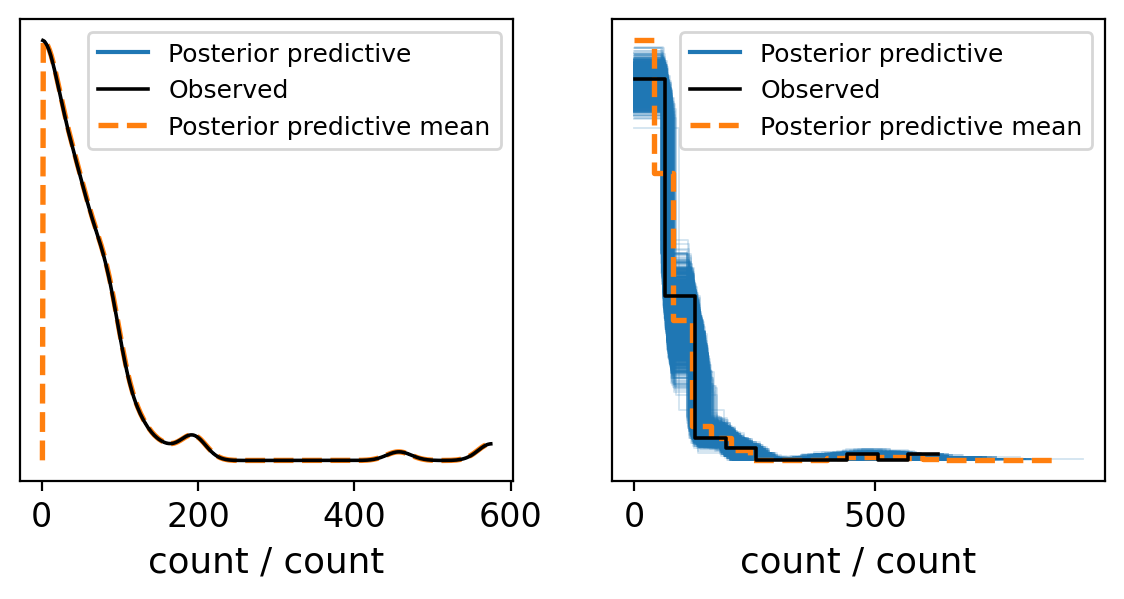

In [9]:
with Normal:
    pm.compute_log_likelihood(trace_NCP)
    pm.sample_posterior_predictive(trace_NCP, extend_inferencedata=True)
with NB_CP:
    pm.compute_log_likelihood(trace_NBCP)
    pm.sample_posterior_predictive(trace_NBCP, extend_inferencedata=True)
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
_ = az.plot_ppc(trace_NCP, group='posterior',ax = axes[0],textsize = 12)
_ = az.plot_ppc(trace_NBCP, group='posterior',ax = axes[1],textsize = 12)


Based on the samples from the posterior predictive checks, it's evident that the Negative Binomial (NB) model provides a better fit to the observed data. However, this model aggregates all information from Ht0 and the priors, essentially smoothing over the details. Is there an opportunity for refinement? Definitely. In pursuit of enhanced model performance, we plan to investigate various strategies, including no pooling and partial pooling.

Such exploration naturally progresses into the domain of hierarchical approaches, where each group is assigned an independent prior. With 96 distinct sgRNAs per sample in our dataset, the hierarchical method becomes particularly appealing. Under this scheme, during the HMC (Hamiltonian Monte Carlo) sampling process, a unique parameter will be estimated for every one of these sgRNAs, promising a more nuanced and potentially more accurate modeling of our data.

Building upon the exploration of enhancing our model's performance, it's valuable to further explain the “no-pooling” and “partial pooling” strategies in the context of hierarchical approaches.

The “no-pooling” approach is intriguingly described in McElreath's Rethinking book as an “amnesia” process. In this strategy, every simulation step independently draws a new parameter from the distribution, entirely unaffected by the population-level estimation (Equation 3). This method treats each group as distinct and separate, without leveraging the collective insights that could be gained from considering the broader trends across groups.

Contrastingly, the “partial pooling” strategy allows the population-level estimation to influence the group-level draw. This approach acknowledges that while each group may exhibit unique behaviors or characteristics, there is value in the shared patterns observed across the entire population. This method seeks a middle ground, where parameters are estimated with an awareness of both individual group dynamics and overarching population trends (Equation 4).

Adding these insights provides a clearer, more holistic view of how “no-pooling” and “partial pooling” operate within hierarchical modeling, paving the way for deeper understanding and application of these methods.

$$
\begin{align*}
&\begin{aligned}
\text{(3)}\\
(H_{t_1,i} | H_{t_0,i}) &\sim \text{NB}(\mu, \alpha)\\
\beta_{i} &= \alpha + \beta_{i} \times H_{t_0,i}\\
\beta_{i} &\sim Normal(1,1)\\
\end{aligned}
&&
\begin{aligned}
\text{OR}\\
\end{aligned}
&&&
\begin{aligned}
\text{(4)}\\
(H_{t_1,i} | H_{t_0,i}) &\sim \text{NB}(\mu, \alpha)\\
\beta_{i} &= \alpha + \beta_{i} \times H_{t_0,i}\\
\beta_{i} &\sim Normal(\bar{beta} \sim Normal(1,1), \bar{sigma} \sim HlfNor(1))\\
\end{aligned}
\end{align*}
$$


Start with the no-pooling approach:

In [ ]:
with pm.Model(coords=coords) as NB_noPooling:
  #Hyper-proirs
  beta = pm.Normal("beta", 1,1,dims=("sgRNA"))

  Mu = pm.Deterministic("Mu",h1+beta[sgRNA]*h0)
  sigma = pm.Gamma("sigma",mu = 28.5, sigma = 10.5)

  count = pm.NegativeBinomial("count",mu = Mu, alpha = sigma, observed=h1)
  trace_noPooling = pm.sample(1000, tune=1000, nuts_sampler="numpyro", target_accept=0.95,chains = 4, random_seed=RANDOM_SEED)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Than partial pooling

In [ ]:
with pm.Model(coords=coords) as NB_partialPooling:
  #Hyper-proirs
  beta_bar = pm.Normal("beta_bar", 1, 1)
  sigma_bar = pm.HalfNormal("sigma_bar", 1)

  #noncenterd
  z_beta = pm.Normal("z_beta", 0, 1, dims=("sgRNA"))
  beta = pm.Deterministic("beta", beta_bar + z_beta*sigma_bar)

  Mu = pm.Deterministic("Mu",h1+beta[sgRNA]*h0)
  sigma = pm.Gamma("sigma",mu = 28.5, sigma = 10.5)

  count = pm.NegativeBinomial("count",mu = Mu, alpha = sigma, observed=h1)
  trace_partialPooling = pm.sample(1000, tune=1000, nuts_sampler="numpyro", target_accept=0.95,chains = 4, random_seed=RANDOM_SEED)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

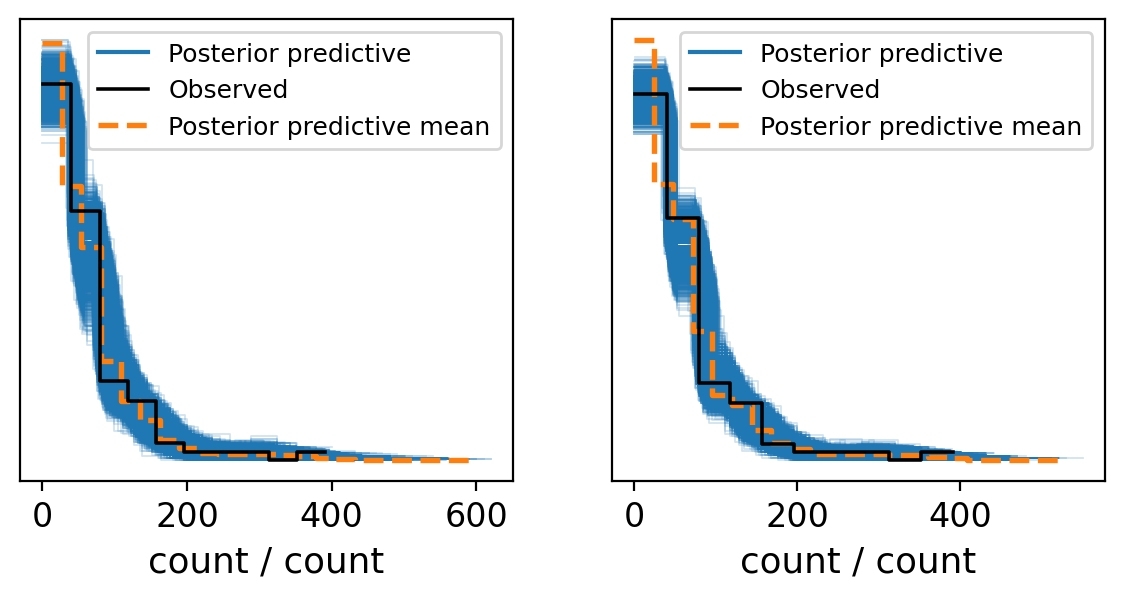

In [ ]:
with NB_noPooling:
    pm.compute_log_likelihood(trace_noPooling)
    pm.sample_posterior_predictive(trace_noPooling, extend_inferencedata=True)
with NB_partialPooling:
    pm.compute_log_likelihood(trace_partialPooling)
    pm.sample_posterior_predictive(trace_partialPooling, extend_inferencedata=True)
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
_ = az.plot_ppc(trace_noPooling, group='posterior',ax = axes[0],textsize = 12)
_ = az.plot_ppc(trace_partialPooling, group='posterior',ax = axes[1],textsize = 12)

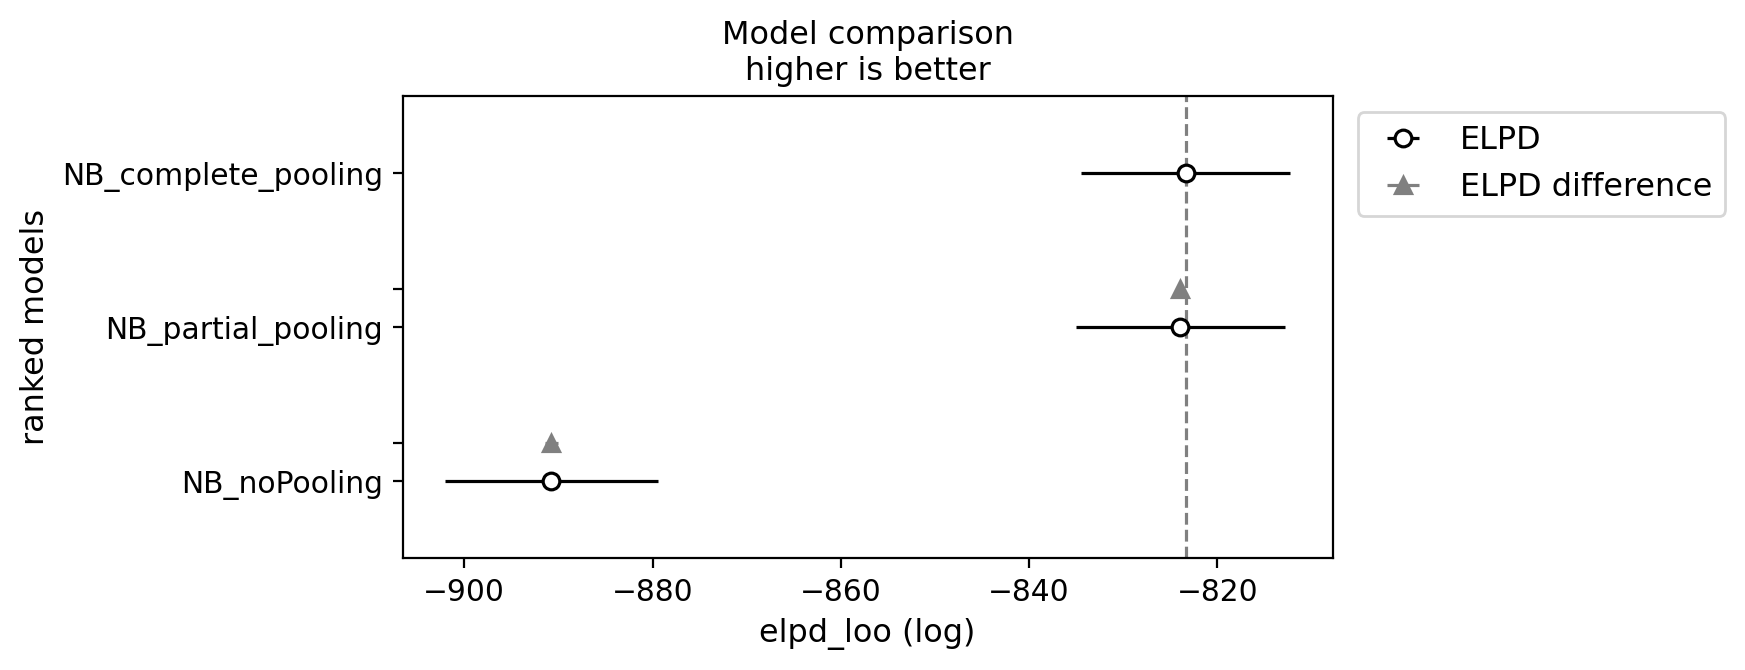

In [ ]:
df_comp_loo = az.compare({"NB_complete_pooling": trace_NBCP, "NB_noPooling": trace_noPooling, "NB_partial_pooling": trace_partialPooling})
_ = az.plot_compare(df_comp_loo, insample_dev=False);

Deciphering the results from posterior predictive checks can be challenging when trying to determine which model performs better. However, the Bayesian framework equips us with a plethora of tools for model comparison. In essence, these tools allow us to compare models based on their expected log pointwise predictive density (ELPD), utilizing information criteria for model ranking. For a more detailed explanation, refer to Chapter 7 (page 207, second edition) of *Statistical Rethinking* by McElreath. Interestingly, in our analysis, there seems to be no significant difference between the partial pooling and complete pooling approaches. We will, therefore, continue our journey, focusing on refining the partial pooling model.

One of the most thrilling aspects of the Bayesian approach is its efficiency in harnessing information to reduce uncertainty. It operates on the principle that leaving no information unused can help decrease uncertainty. This approach is beneficial, especially when considering the natural high dispersion in our datasets across features (sgRNAs) and samples, attributed to complex biological variability and experimental conditions.

A notable factor contributing to this dispersion is the high multiplicity of infection (MOI) strategy. Employing a high MOI, where cells are exposed to more than one sgRNA, aids in ensuring comprehensive genomic coverage. However, the coexistence of multiple sgRNAs within a single cell complicates identifying the sgRNA responsible for specific changes in cellular fitness. Addressing this complexity calls for a sophisticated approach to data analysis that acknowledges and adjusts for the potential overrepresentation of sgRNAs due to high MOI.

The introduction of a high MOI brings about a collider effect—a statistical phenomenon that emerges when the relationship between two variables (sgRNA and cellular fitness, in our context) is influenced by a third variable (MOI). This effect can cloud the actual influence of specific sgRNAs on cellular fitness, leading to possible misinterpretations of our findings. To effectively tackle this issue and minimize the confounding impact, it's crucial to include data on sgRNA abundance before infection. This inclusion sets a reference point, making post-treatment changes more discernible.

Additionally, factoring in sgRNA efficiency, derived from preceding CRISPR screen data, aids in accommodating variability in sgRNA performance. These critical adjustments enhance our comprehension of the role sgRNAs play in cellular fitness, paving the way for interpretations of the data that thoughtfully consider the collider effect introduced by high MOI.

https://towardsdatascience.com/a-step-by-step-guide-in-detecting-causal-relationships-using-bayesian-structure-learning-in-python-c20c6b31cee5

In [ ]:
!pip install -U bnlearn

[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


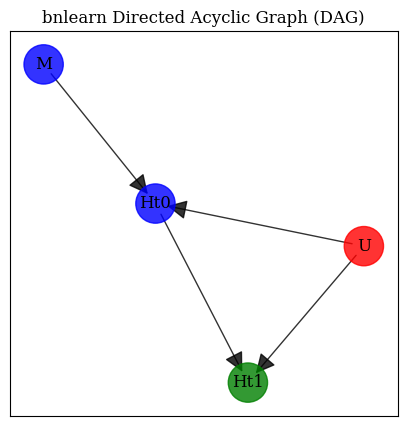

In [ ]:
plt.rcParams["font.family"] = "serif"
import bnlearn as bn
df = pd.DataFrame({"M", "Ht0", "Ht1", "U"})
edges = [("Ht0", "Ht1"),
         ('M', 'Ht0'),
         ('U', 'Ht0'),
         ('U', 'Ht1')]
DAG = bn.make_DAG(edges)
node_properties = bn.get_node_properties(DAG)
node_properties['U']['node_color']='#FF0000'
node_properties['M']['node_color']='#0000FF'
node_properties['Ht0']['node_color']='#0000FF'
node_properties['Ht1']['node_color']='#008000'
_ = bn.plot(DAG, node_properties=node_properties, interactive=False,params_static = {'width':5, 'height':5, 'font_size':12, 'font_family':'serif', 'alpha':0.8, 'node_shape':'o', 'facecolor':'white', 'font_color':'#000000'})

Deciphering the results from posterior predictive checks can be challenging when trying to determine which model performs better. However, the Bayesian framework equips us with a plethora of tools for model comparison. In essence, these tools allow us to compare models based on their expected log pointwise predictive density (ELPD), utilizing information criteria for model ranking. For a more detailed explanation, refer to Chapter 7 (page 207, second edition) of *Statistical Rethinking* by McElreath. Interestingly, in our analysis, there seems to be no significant difference between the partial pooling and complete pooling approaches. We will, therefore, continue our journey, focusing on refining the partial pooling model.

One of the most thrilling aspects of the Bayesian approach is its efficiency in harnessing information to reduce uncertainty. It operates on the principle that leaving no information unused can help decrease uncertainty. This approach is beneficial, especially when considering the natural high dispersion in our datasets across features (sgRNAs) and samples, attributed to complex biological variability and experimental conditions.

A notable factor contributing to this dispersion is the high multiplicity of infection (MOI) strategy. Employing a high MOI, where cells are exposed to more than one sgRNA, aids in ensuring comprehensive genomic coverage. However, the coexistence of multiple sgRNAs within a single cell complicates identifying the sgRNA responsible for specific changes in cellular fitness. Addressing this complexity calls for a sophisticated approach to data analysis that acknowledges and adjusts for the potential overrepresentation of sgRNAs due to high MOI.

The introduction of a high MOI brings about a collider effect—a statistical phenomenon that emerges when the relationship between two variables (sgRNA and cellular fitness, in our context) is influenced by a third variable (MOI). This effect can cloud the actual influence of specific sgRNAs on cellular fitness, leading to possible misinterpretations of our findings. To effectively tackle this issue and minimize the confounding impact, it's crucial to include data on sgRNA abundance before infection. This inclusion sets a reference point, making post-treatment changes more discernible.

Additionally, factoring in sgRNA efficiency, derived from preceding CRISPR screen data, aids in accommodating variability in sgRNA performance. These critical adjustments enhance our comprehension of the role sgRNAs play in cellular fitness, paving the way for interpretations of the data that thoughtfully consider the collider effect introduced by high MOI. Building on our analysis, we now turn to incorporating information about our master plasmid into our model using a varying effect. This technique represents a significant advancement in the Bayesian framework, offering the capability to account for how changes in $H_{t0}$ covary with the composition of the master sample before cell infection.

The inclusion of varying effects is more than just a methodological step forward; it's a crucial strategy for enriching our model with depth and specificity. By integrating the master plasmid's (M) compositional data, we enable our model to reflect the nuanced relationship between the initial sgRNA population and subsequent cellular outcomes post-infection. This approach aligns with the overarching goal of reducing uncertainty by leveraging available information to its fullest extent, ensuring that our analysis is both comprehensive and precise. Through this, we enhance our understanding of sgRNA dynamics, leading to more informed interpretations of genetic interactions and their impacts on cellular fitness.

$$
\begin{align*}
(H_{t_1,i} | H_{t_0,i}) &\sim \text{NB}(\mu_{ij}, \alpha)\\
\mu_{ij} &= \alpha + V_{ij} \times \beta_{i} \times H_{t_0,i} + V_{ij} \times \theta_{i} \times M \\
\beta_{i} &\sim Normal(\bar{beta} \sim Normal(1,1), \bar{sigma} \sim HlfNor(1))\\
\theta_{i} &\sim Normal(\tilde{beta} \sim Normal(1,1), \tilde{sigma} \sim HlfNor(1))\\
V_{ij} &\sim \text{MvNormal}(\begin{bmatrix}\mu_{ij=1}\\ \mu_{ij=2}\ \end{bmatrix}, \Sigma_{j})\\
\Sigma_{j} &\sim \text{LKJCholeskyCov}(n=2, eta=3, \nu=\text{HalfNormal}(\sigma = 1)) \\
\end{align*}
$$

In [29]:
coords.keys()

dict_keys(['sgRNA', 'Genes', 'experiment'])

In [37]:
coords["experiment"] = [0, 1]
with pm.Model(coords=coords) as mvn_partialPooling_covar:
  #Hyper-proirs
  beta_bar = pm.Normal("beta_bar", 1, 1)
  sigma_bar = pm.HalfNormal("sigma_bar", 1)

  theta_bar = pm.Normal("theta_bar", 1, 1)
  sigma_theta_bar = pm.HalfNormal("sigma_theta_bar", 1)

  #Hyper-proir noncentered
  z_beta = pm.Normal("z_beta", 0, 1, dims=("sgRNA"))
  beta = pm.Deterministic("beta", beta_bar + z_beta*sigma_bar)

  z_theta = pm.Normal("z_theta", 0, 1, dims=("sgRNA"))
  theta = pm.Normal("theta",theta_bar + z_theta*sigma_theta_bar)

  chol, _, _ = pm.LKJCholeskyCov(
      "chol_cov", n=2, eta=3, sd_dist=pm.Exponential.dist(2.0), compute_corr=True
  )

  delta = pm.Normal("delta", 0, 1, dims=("sgRNA","experiment"))
  ve = pm.Deterministic("ve", pm.math.dot(chol,delta.T).T)

  Mu_Y = pm.Deterministic("Mu_Y",h1 + pm.math.exp(ve[sgRNA,1])*beta[sgRNA]*h0)
  Mu_X = pm.Deterministic("Mu_X",pm.math.exp(ve[sgRNA,0])*theta[sgRNA]*M)

  XY_obs = pm.Data("XY_obs", xy, mutable=True)
  sigma = pm.Gamma("sigma",mu = 28.5, sigma = 10.5,dims = ("experiment"))


  #count_h0 = pm.NegativeBinomial("count_h0",mu = Mu_X, alpha = sigma[0], observed=h0)
  count_h1 = pm.NegativeBinomial("count_h1",mu = Mu_Y, alpha = sigma[1], observed=h1)
  trace_partialPooling_covar_mvn = pm.sample(1000, tune=1000, nuts_sampler="numpyro", target_accept=0.95,chains = 4, random_seed=RANDOM_SEED)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

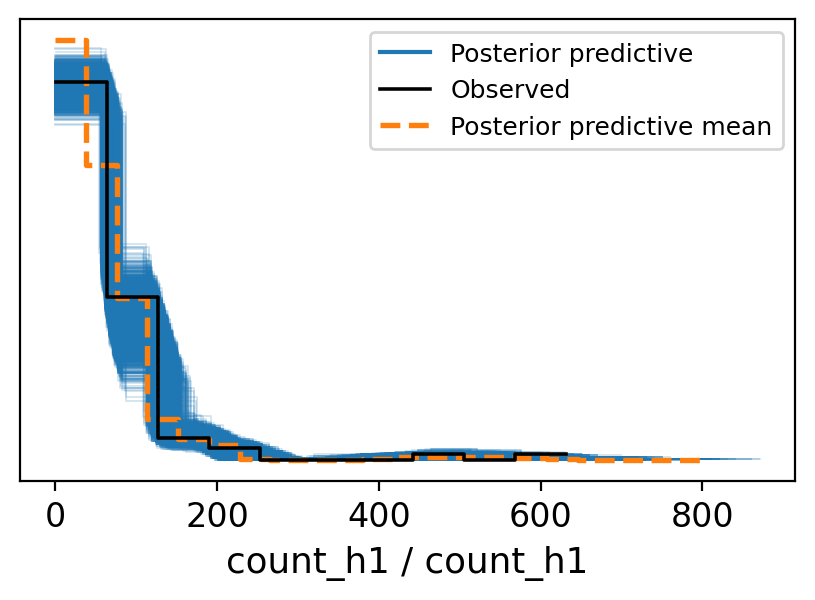

In [40]:
with mvn_partialPooling_covar:
  #pm.compute_log_likelihood(trace_partialPooling_covar_mvn)
  pm.sample_posterior_predictive(trace_partialPooling_covar_mvn, extend_inferencedata=True)
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
_ = az.plot_ppc(trace_partialPooling_covar_mvn, group='posterior',ax = axes,textsize = 12)

In [ ]:
unpooled_means = trace_partialPooling_covar_mvn.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(trace_partialPooling_covar_mvn)

unpooled_means_iter = unpooled_means.sortby("slope")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.slope)

_, ax = plt.subplots(figsize=(12, 5))
xticks = np.arange(0, 86, 6)
unpooled_means_iter.plot.scatter(x="sgRNA", y="slope", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(mn_Genes.size),
    unpooled_hdi_iter.alpha.sel(hdi="lower"),
    unpooled_hdi_iter.alpha.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="FC estimate", ylim=(-2, 4.5))
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.county.values[xticks])
ax.tick_params(rotation=90);